In [1]:
import torch #파이토치
import torchvision.datasets as dsets #MNIST 데이터셋을 불러옴
import torchvision.transforms as transforms #이미지 변환 툴
import torch.nn.init #텐서에 초기값을 줌

import matplotlib.pyplot as plt
import numpy as np

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# 랜덤 시드 고정
torch.manual_seed(777)

# GPU 사용 가능일 경우 랜덤 시드 고정
if device == 'cuda':
    torch.cuda.manual_seed_all(777)

In [3]:
learning_rate = 0.001 #가중치를 얼마나 크게 갱신할지 결정하는 학습률
training_epochs = 15 #반복학습의 횟수
batch_size = 100 #한 iteration에서 사용할 데이터 크기

In [4]:
trainset = dsets.FashionMNIST(
    root      = './.data/', 
    train     = True,
    download  = True,
    transform = transforms.ToTensor()
)

testset = dsets.FashionMNIST(
    root      = './.data/', 
    train     = False,
    download  = True,
    transform = transforms.ToTensor()
)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./.data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./.data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./.data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./.data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./.data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./.data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./.data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./.data/FashionMNIST/raw



In [5]:
train_loader = torch.utils.data.DataLoader(
    dataset     = trainset,
    batch_size  = batch_size,
    shuffle     = True,
)

test_loader = torch.utils.data.DataLoader(
    dataset     = testset,
    batch_size  = batch_size,
    shuffle     = True,
)

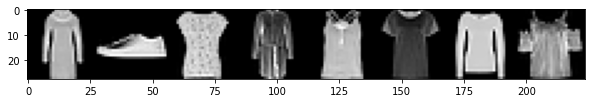

In [6]:
# 데이터(이미지) 확인해보기
from torchvision import utils

dataiter       = iter(train_loader)   # iter함수로 iteration 객체 가져오기
images, labels = next(dataiter)   # next함수로 다음 배치 1개 갖고오기

img   = utils.make_grid(images[:8], padding=0)
npimg = img.numpy()
plt.figure(figsize=(10, 10))
plt.imshow(np.transpose(npimg, (1,2,0)))
plt.show()

# 첫번째 시도

learning rate= 0.001

training epochs=15

batch size=100

In [9]:
# 직접 CNN 클래스를 만들어봅시다.

class CNN(torch.nn.Module):

    def __init__(self):
        super(CNN, self).__init__()
        self.keep_prob = 0.5

        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))
        
        # second layer (32->64)
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))
        
        # third layer (64->128)
        self.layer3 = torch.nn.Sequential(
            torch.nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=1))

        # fourth layer(fully-connected layer, 4x4x128 -> 625)
        self.fc1 = torch.nn.Linear(4 * 4 * 128, 625, bias=True)
        torch.nn.init.xavier_uniform_(self.fc1.weight)   # 가중치 초기화
        self.layer4 = torch.nn.Sequential(
            self.fc1,
            torch.nn.ReLU(),
            torch.nn.Dropout(p=1 - self.keep_prob))
        
        # fifth layer(fully-connected layer, 625 -> 10) 
        self.fc2 = torch.nn.Linear(625, 10, bias=True)
        torch.nn.init.xavier_uniform_(self.fc2.weight)

    def forward(self, x):
        out = self.layer1(x)   # first layer 통과
        out = self.layer2(out)   # second layer 통과
        out = self.layer3(out)   # third layer 통과
        out = out.view(out.size(0), -1)   # fully-connected layer를 위해서 Flatten
        out = self.layer4(out)   # fourth layer 통과
        out = self.fc2(out)   # fifth layer 통과
        return out


In [10]:
model1 = CNN().to(device)


In [11]:
# loss function과 optimizer를 정해봅시다.

criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model1.parameters(), lr=learning_rate)

In [13]:
def training_model(model, data, epochs):
  total_batch = len(data)

  for epoch in range(epochs):
    avg_cost = 0

    for X, Y in data:  #data_loader에 배치들이 저장되어 있음. 한 iteration당 한 개의 배치를 꺼내와서 사용
        X = X.to(device)   #이미지
        Y = Y.to(device)   #레이블(해당 이미지가 뜻하는 숫자)

        optimizer.zero_grad()   #지난 iteration에서 계산했던 기울기 초기화
        hypothesis = model(X)   #순전파 과정으로 예측값 도출
        cost = criterion(hypothesis, Y)   #예측값과 실제값을 비교한 loss
        cost.backward()   #역전파, 기울기 계산
        optimizer.step()   #optimizer로 가중치 갱신

        avg_cost += cost / total_batch

    print('[Epoch: {:>4}] cost = {:>.9}'.format(epoch + 1, avg_cost))

In [14]:
# 모델을 학습시켜봅시다.

training_model(model = model1, data = train_loader, epochs = training_epochs)

[Epoch:    1] cost = 0.514638543
[Epoch:    2] cost = 0.314619005
[Epoch:    3] cost = 0.265846789
[Epoch:    4] cost = 0.234249845
[Epoch:    5] cost = 0.211762637
[Epoch:    6] cost = 0.19597353
[Epoch:    7] cost = 0.176589474
[Epoch:    8] cost = 0.159781381
[Epoch:    9] cost = 0.146556348
[Epoch:   10] cost = 0.133690298
[Epoch:   11] cost = 0.121741928
[Epoch:   12] cost = 0.108381227
[Epoch:   13] cost = 0.0981473178
[Epoch:   14] cost = 0.0885776579
[Epoch:   15] cost = 0.0805876255


In [16]:
# test 데이터를 사용하여 모델의 성능(정확도)을 확인해봅시다.

correct = 0

with torch.no_grad():
    for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model1(data)
            
            pred = output.max(1, keepdim=True)[1]
            # eq() 함수는 값이 일치하면 1을, 아니면 0을 출력.
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_accuracy = correct / len(test_loader.dataset)
    print('Accuracy:', test_accuracy)

Accuracy: 0.9165


# **두번째 시도** 

배치 정규화 진행

drop out rate 0.4로 변경

하이퍼파라미터 값들은 model1과 동일



In [22]:
data_loader = torch.utils.data.DataLoader(dataset=trainset,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          drop_last=True)

test_loader = torch.utils.data.DataLoader(dataset=testset,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          drop_last=True)

In [23]:
class CNN(torch.nn.Module):

    def __init__(self):
        super(CNN, self).__init__()
        self.keep_prob = 0.4  #드롭아웃 확률 조절

        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            torch.nn.BatchNorm2d(32),            
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))
        
        # second layer (32->64)
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))
        
        # third layer (64->128)
        self.layer3 = torch.nn.Sequential(
            torch.nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            torch.nn.BatchNorm2d(128),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=1))

        # fourth layer(fully-connected layer, 4x4x128 -> 625)
        self.fc1 = torch.nn.Linear(4 * 4 * 128, 625, bias=True)
        torch.nn.init.xavier_uniform_(self.fc1.weight)   # 가중치 초기화
        self.layer4 = torch.nn.Sequential(
            self.fc1,
            torch.nn.ReLU(),
            torch.nn.Dropout(p=1 - self.keep_prob))
        
        # fifth layer(fully-connected layer, 625 -> 10) 
        self.fc2 = torch.nn.Linear(625, 10, bias=True)
        torch.nn.init.xavier_uniform_(self.fc2.weight)

    def forward(self, x):
        out = self.layer1(x)   # first layer 통과
        out = self.layer2(out)   # second layer 통과
        out = self.layer3(out)   # third layer 통과
        out = out.view(out.size(0), -1)   # fully-connected layer를 위해서 Flatten
        out = self.layer4(out)   # fourth layer 통과
        out = self.fc2(out)   # fifth layer 통과
        return out


In [24]:
model2 = CNN().to(device)

criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model2.parameters(), lr=learning_rate)

In [25]:
training_model(model = model2, data = train_loader, epochs = training_epochs)

[Epoch:    1] cost = 0.544950962
[Epoch:    2] cost = 0.346475154
[Epoch:    3] cost = 0.29934597
[Epoch:    4] cost = 0.265551537
[Epoch:    5] cost = 0.24060449
[Epoch:    6] cost = 0.219656318
[Epoch:    7] cost = 0.199453667
[Epoch:    8] cost = 0.184835374
[Epoch:    9] cost = 0.168639421
[Epoch:   10] cost = 0.156388924
[Epoch:   11] cost = 0.141662538
[Epoch:   12] cost = 0.128385946
[Epoch:   13] cost = 0.115516104
[Epoch:   14] cost = 0.10823442
[Epoch:   15] cost = 0.0963102207


In [26]:
correct = 0

with torch.no_grad():
    for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model2(data)
            
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_accuracy = correct / len(test_loader.dataset)
    print('Accuracy:', test_accuracy)

Accuracy: 0.9173


정확도 0.9173으로 증가 

# **세번째 시도**

배치 정규화 

batch size만 50으로 변경 

In [28]:
learning_rate = 0.001 #가중치를 얼마나 크게 갱신할지 결정하는 학습률
training_epochs = 15 #반복학습의 횟수
batch_size = 50 #한 iteration에서 사용할 데이터 크기

In [29]:
data_loader = torch.utils.data.DataLoader(dataset=trainset,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          drop_last=True)

test_loader = torch.utils.data.DataLoader(dataset=testset,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          drop_last=True)

In [30]:
class CNN(torch.nn.Module):

    def __init__(self):
        super(CNN, self).__init__()
        self.keep_prob = 0.4  #드롭아웃 확률 조절

        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            torch.nn.BatchNorm2d(32),            
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))
        
        # second layer (32->64)
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))
        
        # third layer (64->128)
        self.layer3 = torch.nn.Sequential(
            torch.nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            torch.nn.BatchNorm2d(128),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=1))

        # fourth layer(fully-connected layer, 4x4x128 -> 625)
        self.fc1 = torch.nn.Linear(4 * 4 * 128, 625, bias=True)
        torch.nn.init.xavier_uniform_(self.fc1.weight)   # 가중치 초기화
        self.layer4 = torch.nn.Sequential(
            self.fc1,
            torch.nn.ReLU(),
            torch.nn.Dropout(p=1 - self.keep_prob))
        
        # fifth layer(fully-connected layer, 625 -> 10) 
        self.fc2 = torch.nn.Linear(625, 10, bias=True)
        torch.nn.init.xavier_uniform_(self.fc2.weight)

    def forward(self, x):
        out = self.layer1(x)   # first layer 통과
        out = self.layer2(out)   # second layer 통과
        out = self.layer3(out)   # third layer 통과
        out = out.view(out.size(0), -1)   # fully-connected layer를 위해서 Flatten
        out = self.layer4(out)   # fourth layer 통과
        out = self.fc2(out)   # fifth layer 통과
        return out


In [31]:
model3 = CNN().to(device)

criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model3.parameters(), lr=learning_rate)

In [33]:
training_model(model = model3, data = train_loader, epochs = training_epochs)

[Epoch:    1] cost = 0.523584187
[Epoch:    2] cost = 0.343520492
[Epoch:    3] cost = 0.287563682
[Epoch:    4] cost = 0.257747442
[Epoch:    5] cost = 0.23634468
[Epoch:    6] cost = 0.215305403
[Epoch:    7] cost = 0.196663588
[Epoch:    8] cost = 0.180733413
[Epoch:    9] cost = 0.169401914
[Epoch:   10] cost = 0.154668212
[Epoch:   11] cost = 0.140885815
[Epoch:   12] cost = 0.129713297
[Epoch:   13] cost = 0.114961624
[Epoch:   14] cost = 0.106577642
[Epoch:   15] cost = 0.0959334299


In [34]:
correct = 0

with torch.no_grad():
    for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model3(data)
            
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_accuracy = correct / len(test_loader.dataset)
    print('Accuracy:', test_accuracy)

Accuracy: 0.9178


정확도 0.9178로 증가

# 네번째 시도

배치 정규화

세번째 시도와 하이퍼파라미터는 같음

drop out rate 0.3으로 조정

In [42]:
class CNN(torch.nn.Module):

    def __init__(self):
        super(CNN, self).__init__()
        self.keep_prob = 0.3  #드롭아웃 확률 조절

        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            torch.nn.BatchNorm2d(32),            
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))
        
        # second layer (32->64)
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))
        
        # third layer (64->128)
        self.layer3 = torch.nn.Sequential(
            torch.nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            torch.nn.BatchNorm2d(128),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=1))

        # fourth layer(fully-connected layer, 4x4x128 -> 625)
        self.fc1 = torch.nn.Linear(4 * 4 * 128, 625, bias=True)
        torch.nn.init.xavier_uniform_(self.fc1.weight)   # 가중치 초기화
        self.layer4 = torch.nn.Sequential(
            self.fc1,
            torch.nn.ReLU(),
            torch.nn.Dropout(p=1 - self.keep_prob))
        
        # fifth layer(fully-connected layer, 625 -> 10) 
        self.fc2 = torch.nn.Linear(625, 10, bias=True)
        torch.nn.init.xavier_uniform_(self.fc2.weight)

    def forward(self, x):
        out = self.layer1(x)   # first layer 통과
        out = self.layer2(out)   # second layer 통과
        out = self.layer3(out)   # third layer 통과
        out = out.view(out.size(0), -1)   # fully-connected layer를 위해서 Flatten
        out = self.layer4(out)   # fourth layer 통과
        out = self.fc2(out)   # fifth layer 통과
        return out


In [44]:
model4 = CNN().to(device)

criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model4.parameters(), lr=learning_rate)

In [45]:
training_model(model = model4, data = train_loader, epochs = training_epochs)

[Epoch:    1] cost = 0.585837603
[Epoch:    2] cost = 0.380939782
[Epoch:    3] cost = 0.320037663
[Epoch:    4] cost = 0.287987947
[Epoch:    5] cost = 0.262117922
[Epoch:    6] cost = 0.244631946
[Epoch:    7] cost = 0.220476419
[Epoch:    8] cost = 0.203021228
[Epoch:    9] cost = 0.188826412
[Epoch:   10] cost = 0.175197884
[Epoch:   11] cost = 0.164674565
[Epoch:   12] cost = 0.147118241
[Epoch:   13] cost = 0.137204364
[Epoch:   14] cost = 0.123984732
[Epoch:   15] cost = 0.11890199


In [47]:
correct = 0

with torch.no_grad():
    for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model4(data)
            
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_accuracy = correct / len(test_loader.dataset)
    print('Accuracy:', test_accuracy)

Accuracy: 0.9147


정확도 0.9147로 하락

# 다섯번째 시도

배치정규화

drop out = 0.4로 다시 조정

pooling 방법을 max -> average 변경 

(해당 윈도우에 들어가는 요소 값 중 최댓값만 뽑아내는게 max pooling 방식, 그 요소들의 평균 값을 뽑아내는 것이 Average pooling 방식)

In [49]:
class CNN(torch.nn.Module):

    def __init__(self):
        super(CNN, self).__init__()
        self.keep_prob = 0.4  #드롭아웃 확률 조절

        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            torch.nn.BatchNorm2d(32),            
            torch.nn.ReLU(),
            torch.nn.AvgPool2d(kernel_size=2, stride=2))
        
        # second layer (32->64)
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(),
            torch.nn.AvgPool2d(kernel_size=2, stride=2))
        
        # third layer (64->128)
        self.layer3 = torch.nn.Sequential(
            torch.nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            torch.nn.BatchNorm2d(128),
            torch.nn.ReLU(),
            torch.nn.AvgPool2d(kernel_size=2, stride=2, padding=1))

        # fourth layer(fully-connected layer, 4x4x128 -> 625)
        self.fc1 = torch.nn.Linear(4 * 4 * 128, 625, bias=True)
        torch.nn.init.xavier_uniform_(self.fc1.weight)   # 가중치 초기화
        self.layer4 = torch.nn.Sequential(
            self.fc1,
            torch.nn.ReLU(),
            torch.nn.Dropout(p=1 - self.keep_prob))
        
        # fifth layer(fully-connected layer, 625 -> 10) 
        self.fc2 = torch.nn.Linear(625, 10, bias=True)
        torch.nn.init.xavier_uniform_(self.fc2.weight)

    def forward(self, x):
        out = self.layer1(x)   # first layer 통과
        out = self.layer2(out)   # second layer 통과
        out = self.layer3(out)   # third layer 통과
        out = out.view(out.size(0), -1)   # fully-connected layer를 위해서 Flatten
        out = self.layer4(out)   # fourth layer 통과
        out = self.fc2(out)   # fifth layer 통과
        return out


In [50]:
model5 = CNN().to(device)

criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model5.parameters(), lr=learning_rate)

In [51]:
training_model(model = model5, data = train_loader, epochs = training_epochs)

[Epoch:    1] cost = 0.482134312
[Epoch:    2] cost = 0.315882444
[Epoch:    3] cost = 0.274261117
[Epoch:    4] cost = 0.246327162
[Epoch:    5] cost = 0.226640001
[Epoch:    6] cost = 0.207584605
[Epoch:    7] cost = 0.195009723
[Epoch:    8] cost = 0.179345846
[Epoch:    9] cost = 0.16803427
[Epoch:   10] cost = 0.157867506
[Epoch:   11] cost = 0.144192845
[Epoch:   12] cost = 0.131072387
[Epoch:   13] cost = 0.123534366
[Epoch:   14] cost = 0.116329424
[Epoch:   15] cost = 0.105775885


In [52]:
correct = 0

with torch.no_grad():
    for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model5(data)
            
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_accuracy = correct / len(test_loader.dataset)
    print('Accuracy:', test_accuracy)

Accuracy: 0.927


정확도 0.927로 상승